## Código de honor

“Al entregar la solución de este parcial, yo, <span style="color:red"> Nicolás Klopstock</span> con código <span style="color:red">202021352</span> me comprometo a no conversar durante el desarrollo de este examen con ninguna persona que no sea el profesor del curso, sobre aspectos relacionados con el parcial; tampoco utilizaré algún medio de comunicación por voz, texto o intercambio de archivos, para consultar o compartir con otros, información sobre el tema del parcial. Soy consciente y acepto las consecuencias que acarreará para mi desempeño académico cometer fraude en este parcial”.

# Desarrollo Parcial

## Imports y carga de datos

In [ ]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from joblib import dump, load
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

import scipy.stats as stats
from sklearn import tree

In [ ]:
df = pd.read_csv('data/autos_alpes.csv', encoding="ISO-8859-1", sep=',')
df.head()

,uid,product_id,type,air_temperature,process_temperature,rotational_speed,torque,tool_wear,machine_failure,twf,hdf,pwf,osf,rnf
0,6586,M21445,M,301.5,310.5,1600.0,32.8,205.0,0,0,0,0,0,0
1,3017,L50196,L,300.5,309.8,1441.0,48.8,200.0,0,0,0,0,0,0
2,1704,M16563,M,298.1,307.8,1636.0,36.7,51.0,0,0,0,0,0,0
3,8575,L55754,L,297.6,308.3,1424.0,53.9,132.0,0,0,0,0,0,0
4,5444,M20303,M,303.0,312.7,1426.0,46.8,99.0,0,0,0,0,0,0


## 1. Enfoque Analítico

El enfoque análitico que le daremos al ejercicio de consultoría es el siguiente. Primero, se va valorar la calidad de los datos y analizarlos según sus valores y reglas del negocio. Los valores que se salgan del rango establecido para la muestra de datos, (dependiendo su porcentaje) se ajustarán para que lo cumplan, se corregirán los valores String que no correspondan a los definidos para la muestra y se hará un *encoding* de los valores de las variables categóricas.

Una vez corregidos los datos, se va a elegir la variable objetivo (*machine_failures*). Luego, se va a revisar la correlación entre cada *feature* elegida, para entender cuales -tal vez- no son tan necesarias o su efecto se ve reflejado en otra variable.

Finalmente, se va a entrenar un modelo de aprendizaje supervisado de clasificación. Se clasifica como supervisado, porque le estamos dando las características que tienen que tener en cuenta al momento de clasificar. Este modelo se va a entrenar usando datos de entrenamiento que nos ayudan a predecir sobre datos de prueba. Los modelos están orientados a dos algoritmos de clasificación: Árbol de Decisión y Bosque de Árboles de Decisión. Para cada uno, analizaremos sus métricas y veremos cuál nos da un modelo más generalizado para posibles datos de prueba futuros.

## 2. Análisis exploratorio y de calidad de datos

### Limpieza y revisión de datos

Para empezar a entender los datos, debemos revisar el tamaño total de los mismos, además de sus tipos.

In [ ]:
df.shape

(1305, 14)

In [ ]:
df.dtypes

uid                      int64
product_id              object
type                    object
air_temperature        float64
process_temperature    float64
rotational_speed       float64
torque                 float64
tool_wear              float64
machine_failure          int64
twf                      int64
hdf                      int64
pwf                      int64
osf                      int64
rnf                      int64
dtype: object

Ahora, se revisa el porcentaje de valores nulos de cada columna del DataFrame.

In [ ]:
(df.isnull().sum() / df.shape[0]).sort_values(ascending=False)

process_temperature    0.055939
air_temperature        0.052107
rotational_speed       0.049042
tool_wear              0.047510
torque                 0.045977
type                   0.007663
uid                    0.000000
product_id             0.000000
machine_failure        0.000000
twf                    0.000000
hdf                    0.000000
pwf                    0.000000
osf                    0.000000
rnf                    0.000000
dtype: float64

Se van a examinar los diferentes datos de cada columna, para revisar si hubo errores en la toma de los mismos (errores de formato y/o rango).

#### UID

In [ ]:
df['uid'].unique()

array([6586, 3017, 1704, ..., 9823, 9831, 9975])

#### Producto ID

In [ ]:
df['product_id'].unique()

array(['M21445', 'L50196', 'M16563', ..., 'L57002', 'L57010', 'L57154'],
      dtype=object)

#### Type

In [ ]:
df['type'].unique()

array(['M', 'L', 'H', nan, 'h', 'l', 'm', 'mm'], dtype=object)

Hay que reemplazar varios valores en formatos diferentes al esperado

In [ ]:
type_mode = df['type'].mode()[0]
df['type'] = df['type'].replace(['h', 'l', 'm', 'mm'], ['H', 'L', 'M', 'M'])
df['type'].fillna(type_mode, inplace=True)

In [ ]:
df['type'].unique()

array(['M', 'L', 'H'], dtype=object)

In [ ]:
# Hacer un encoding de los valores la columna 'type'.
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])
df['type'].unique()

array([2, 1, 0])

<Axes: ylabel='type'>

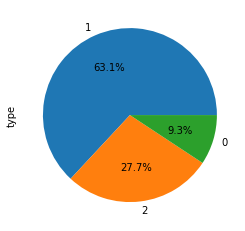

In [ ]:
df['type'].value_counts().plot(kind='pie', autopct='%1.1f%%')

In [ ]:
df['type'].describe()

count    1305.000000
mean        1.183908
std         0.579469
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         2.000000
Name: type, dtype: float64

In [ ]:
process_mode = df['type'].mode()[0]
process_mode

1

La media y la moda son estadísticamente iguales, podemos usar cualquiera de las dos.

In [ ]:
df['type'].fillna(process_mode, inplace=True)

In [ ]:
df['type'].isnull().sum()

0

<Axes: ylabel='type'>

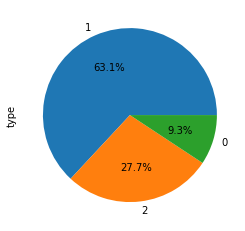

In [ ]:
df['type'].value_counts().plot(kind='pie', autopct='%1.1f%%')

#### Air Temperature

In [ ]:
df['air_temperature'].unique()

array([ 301.5,  300.5,  298.1,  297.6,  303. ,  297.4,  300.7,  297.3,
        300.9,  301.6,  301. ,  296.1,    nan,  301.1,  298.7,  300.4,
        298.2,  296.7,  297.9,  296.4,  303.6,  298. ,  299.1,  299.4,
        297.5,  300.2,  295.6,  297.8,  300.3,  298.8,  302.3,  299.2,
        297.7,  296.2,  302.6,  299.5,  300.8,  300.6,  303.8,  301.2,
        300.1,  304. ,  302.4,  298.6,  302.2,  299.8,  302.1,  301.9,
        298.5,  303.4,  302.5,  299.9,  304.2,  301.3,  298.4,  301.8,
        298.3,  296.8,  303.1,  302.7,  303.7,  295.9,  298.9,  297.1,
        299.3,  303.2,  299. ,  302. ,  296.6,  299.6,  301.7,  302.8,
        302.9,  300. ,  297.2,  296.9,  297. ,  301.4,  295.8,  303.5,
        295.7,  299.7,  304.1,  296. ,  296.5,  295.5,  303.9,  303.3,
        296.3, -299.2,  295.4, -298.1,  304.4])

Hay un valor fuera del rango (es negativo).

In [ ]:
df['air_temperature'] = df['air_temperature'].abs()

<Axes: ylabel='Frequency'>

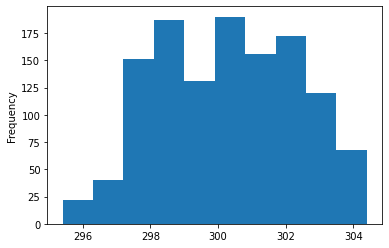

In [ ]:
df['air_temperature'].plot.hist()

In [ ]:
df['air_temperature'].describe()

count    1237.000000
mean      300.234923
std         2.047374
min       295.400000
25%       298.600000
50%       300.400000
75%       301.900000
max       304.400000
Name: air_temperature, dtype: float64

In [ ]:
process_mode = df['air_temperature'].mode()[0]
process_mode

298.8

La media y la moda son estadísticamente iguales, podemos usar cualquiera de las dos.

In [ ]:
df['air_temperature'].fillna(process_mode, inplace=True)

In [ ]:
df['air_temperature'].isnull().sum()

0

#### Process Temperature

In [ ]:
df['process_temperature'].unique()

array([ 310.5,  309.8,  307.8,  308.3,  312.7,  308.4,  311. ,  310.4,
        310.9,  312.1,  306.9,  312.3,  311.2,  309.9,  307.9,  311.1,
        307.6,  307.4,  307. ,  310.2,  312.8,  307.5,  312. ,    nan,
        309.4,  311.4,  306.1,  308.5,  310.3,  308.1,  308.8,  309.6,
        308. ,  308.6,  309.7,  310.6,  311.6,  312.9,  311.8,  309. ,
        309.1,  312.4,  309.3,  307.3,  313.1,  310.8,  311.7,  311.5,
        313.3,  311.3,  313.5,  313. ,  310.1,  312.6,  308.9,  306.6,
        308.7,  307.7,  310. ,  309.2,  310.7,  309.5,  311.9,  307.1,
        313.4,  312.5,  308.2,  312.2,  306.2,  306.8,  313.2,  307.2,
        306.5,  313.6,  306. ,  306.7,  306.3,  305.8, -309.9,  313.7])

Hay un datos que est´afuera del rango (es negativo).

In [ ]:
df['process_temperature'] = df['process_temperature'].abs()

<Axes: ylabel='Frequency'>

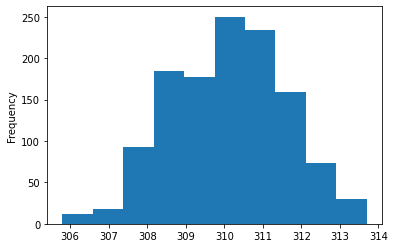

In [ ]:
df['process_temperature'].plot.hist()

In [ ]:
df['process_temperature'].describe()

count    1232.000000
mean      310.092857
std         1.490451
min       305.800000
25%       308.975000
50%       310.200000
75%       311.200000
max       313.700000
Name: process_temperature, dtype: float64

In [ ]:
process_mode = df['process_temperature'].mode()[0]
process_mode

308.6

La media y la moda son estadísticamente iguales, podemos usar cualquiera de las dos.

In [ ]:
df['process_temperature'].fillna(process_mode, inplace=True)

In [ ]:
df['process_temperature'].isnull().sum()

0

#### Rotational Speed

In [ ]:
df['rotational_speed'].unique()

array([1600., 1441., 1636., 1424., 1426., 1571., 1403., 1491., 1536.,
       1643., 1664., 1951., 1543., 1427., 1384., 1483., 1421., 1529.,
       1325., 1690., 1493., 1523., 1771., 1702., 1701., 1683., 1447.,
       1892., 1372.,   nan, 1695., 1655., 1495., 1669., 1371., 1418.,
       1345., 1618., 1991., 1675., 1456., 1521., 1448., 1502., 1901.,
       1428., 1526., 1570., 1609., 1611., 1747., 1496., 1716., 1751.,
       1368., 1474., 1429., 1630., 1619., 1841., 1305., 1707., 1607.,
       1984., 1553., 1433., 1699., 1363., 1578., 1438., 1408., 1583.,
       1460., 1698., 1981., 1498., 1549., 2129., 1515., 1740., 1410.,
       1477., 1509., 1824., 1417., 1436., 1844., 1566., 1703., 1601.,
       1329., 1470., 1546., 1685., 1432., 1431., 1279., 1678., 1793.,
       1617., 1362., 1679., 1286., 1451., 1374., 1596., 1486., 1480.,
       2189., 1494., 1684., 1757., 1326., 1501., 1406., 1437., 1762.,
       1516., 1316., 1724., 1461., 1352., 1557., 1294., 1314., 1614.,
       1500., 1717.,

<Axes: ylabel='Frequency'>

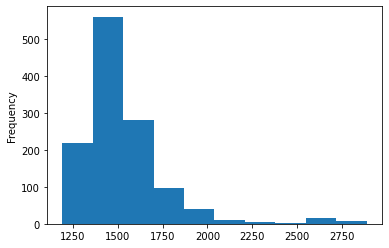

In [ ]:
df['rotational_speed'].plot.hist()

In [ ]:
df['rotational_speed'].describe()

count    1241.000000
mean     1535.970991
std       243.333697
min      1192.000000
25%      1381.000000
50%      1477.000000
75%      1612.000000
max      2886.000000
Name: rotational_speed, dtype: float64

In [ ]:
process_mode = df['rotational_speed'].mode()[0]
process_mode

1372.0

La media y la moda son estadísticamente iguales, podemos usar cualquiera de las dos.

In [ ]:
df['rotational_speed'].fillna(process_mode, inplace=True)

In [ ]:
df['rotational_speed'].isnull().sum()

0

#### Torque

In [ ]:
df['torque'].unique()

array([32.8, 48.8, 36.7, 53.9, 46.8, 39.4, 48.3, 46.5, 34.2, 34.1, 28.4,
       23.3, 33.3, 47. , 49.4, 47.2, 36.6, 61.4, 29.6,  nan, 48.4, 42. ,
       26.8, 29.3, 30.8, 27.8, 41.4, 46.3, 40.8, 26.7, 28.7, 43.6, 29. ,
       55.5, 41.2, 34.7, 20.7, 35.5, 42.4, 34.8, 51.4, 28.5, 48.9, 41. ,
       22.1, 45.3, 37.3, 31. , 39.9, 25.3, 38.5, 26.6, 27.9, 52.7, 31.8,
       24.6, 51.7, 30. , 33.7, 19.7, 32.6, 30.3, 53.1, 30.5, 44.5, 39.8,
       52. , 32.1, 53.7, 33.2, 21.8, 38.1, 18.7, 47.4, 49. , 48.5, 47.3,
       24. , 47.6, 51.9, 50.8, 27.1, 37.6, 40.2, 40.9, 33.1, 28.2, 49.8,
       52.3, 55.9, 38.9, 31.6, 56.3, 32.4, 60.5, 37.2, 41.1, 42.9, 15.6,
       43.2, 42.7, 38.8, 41.9, 43.3, 39. , 45.4, 52.8, 36. , 43.8, 59.4,
       59.5, 33.5, 41.6, 31.3, 44. , 48.1, 29.8, 45.5, 34.6, 38.3, 39.7,
       44.1, 24.2, 25.6, 46.6, 42.5, 42.8, 30.2, 52.4, 24.7, 35.7, 27.2,
       23.9, 45.2, 35.6, 49.5, 41.8, 23.6, 32. , 32.2, 47.7, 37.4, 47.9,
       50.2, 19.4, 58.6, 56.9, 36.3, 55.3, 28.3, 28

<Axes: ylabel='Frequency'>

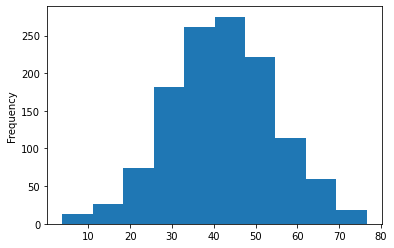

In [ ]:
df['torque'].plot.hist()

In [ ]:
df['torque'].describe()

count    1245.000000
mean       42.002329
std        12.696073
min         3.800000
25%        33.400000
50%        42.000000
75%        50.300000
max        76.600000
Name: torque, dtype: float64

In [ ]:
process_mode = df['torque'].mode()[0]
process_mode

38.5

La media y la moda son estadísticamente iguales, podemos usar cualquiera de las dos.

In [ ]:
df['torque'].fillna(process_mode, inplace=True)

In [ ]:
df['torque'].isnull().sum()

0

#### Tool Wear

In [ ]:
df['tool_wear'].unique()

array([205., 200.,  51., 132.,  99.,   0.,  70.,  29.,  45.,  44.,  nan,
        38.,  71.,  65.,  48., 142., 105.,  88., 119., 164., 216.,  32.,
        12.,  26., 193.,  34., 173.,  37.,  28.,  20.,  95., 161., 159.,
       155.,  50.,  39.,  59.,  72.,  63., 160., 176.,  81.,  47., 140.,
       190., 210., 136., 162.,   9., 183.,  21.,  53.,  35.,  52., 182.,
       143., 202., 165., 130., 169.,  90.,  76., 178.,   7.,   3.,  57.,
       116., 214., 147.,  36., 121., 126., 170., 223., 138.,   2., 179.,
        10., 153.,  54., 134.,  69., 125.,  58.,  82.,  66., 198.,  11.,
       152., 114., 113., 108., 154., 144.,  87.,  13., 122., 186., 221.,
       167.,   6.,  75., 171., 127.,  92., 120.,  41.,  56., 158., 104.,
        17., 191., 187.,  61., 203.,  67.,  74.,  86.,  33., 196., 188.,
        77.,  43., 227.,  15., 189.,  64., 131., 151., 206., 106., 137.,
        91., 112., 177., 107., 123., 181.,  31., 219.,  62.,  98., 103.,
       133.,  85., 150., 215., 128., 174.,  40.,  1

<Axes: ylabel='Frequency'>

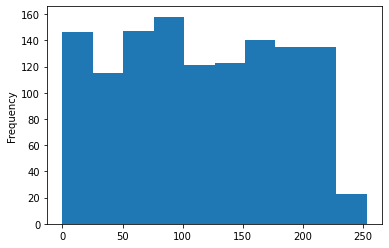

In [ ]:
df['tool_wear'].plot.hist()

In [ ]:
df['tool_wear'].describe()

count    1243.000000
mean      115.325825
std        67.053714
min         0.000000
25%        59.500000
50%       112.000000
75%       174.000000
max       253.000000
Name: tool_wear, dtype: float64

In [ ]:
process_mode = df['tool_wear'].mode()[0]
process_mode

0.0

In [ ]:
df['tool_wear'].fillna(df['tool_wear'].mean(), inplace=True)

In [ ]:
df['tool_wear'].isnull().sum()

0

#### Machine Failure

In [ ]:
df['machine_failure'].unique()

array([0, 1])

<Axes: ylabel='machine_failure'>

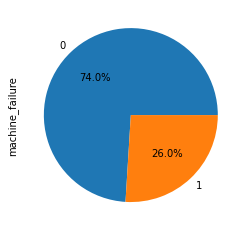

In [ ]:
df["machine_failure"].value_counts().plot(kind='pie', autopct='%1.1f%%')

El siguiente condicional ayuda a, en caso de que un valor de "machine_failure" esté vacío, revisar las columnas de tipos de fallo y compribar si hay un 1. En caso verdadero, se pone el 1 en esa fila para "machine_failure"; en caso contrario, un 0. Esto se hace, ya que no podemos asumir que poner la moda o la mediana no va a cambiar el resultado futuro de los modelos entrenados.

In [ ]:
for i in range(len(df)):
  if pd.isnull(df.loc[i, 'machine_failure']):
      if any(df.loc[i, ['twf', 'hdf', 'pwf', 'osf', 'rnf']] == 1):
          df.loc[i, 'machine_failure'] = 1
      else:
          df.loc[i, 'machine_failure'] = 0

#### Columnas de Falla

In [ ]:
df['twf'].unique()

array([0, 1])

In [ ]:
df['hdf'].unique()

array([0, 1])

In [ ]:
df['pwf'].unique()

array([0, 1])

In [ ]:
df['osf'].unique()

array([0, 1])

In [ ]:
df['rnf'].unique()

array([0, 1])

<Axes: >

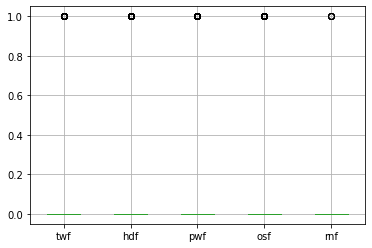

In [ ]:
df.boxplot(column=['twf', 'hdf', 'pwf', 'osf', 'rnf'])

#### Confirmación de valores nulos

In [ ]:
(df.isnull().sum() / df.shape[0]).sort_values(ascending=False)

uid                    0.0
product_id             0.0
type                   0.0
air_temperature        0.0
process_temperature    0.0
rotational_speed       0.0
torque                 0.0
tool_wear              0.0
machine_failure        0.0
twf                    0.0
hdf                    0.0
pwf                    0.0
osf                    0.0
rnf                    0.0
dtype: float64

### Contrucción de Variable Objetivo (para Clasificación)

Se busca un modelo que permita conocer el posible estado de falla de una máquina, para realizar un mantenimiento preventivo. Por esta razón, se va a usar como variable objetivo "machine_failure".

## 3. Entrenamiento modelo Machine Learning

### Machine Learning, Clasificación

#### Selección de *Features*

Las columnas que nos permiten tener una idea clara de la distribución de fallos entre máquinas son aquellas que nos permitan ver qué identifica a una máquina con o sin posibles fallos:

In [ ]:
features = ['type', 'air_temperature', 'process_temperature', 'torque', 'rotational_speed', 'tool_wear']

No se van a tener en cuenta columnas como twf, hdf, pwf, osf ni rnf, porque todas son derivadas de la columna machine_failure. Esto se puede verificar revisando la correlación entre cada par de variables.

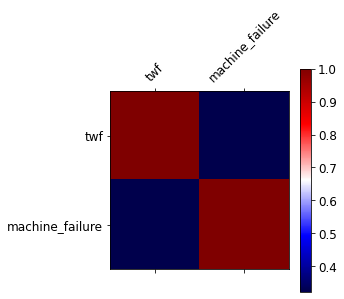

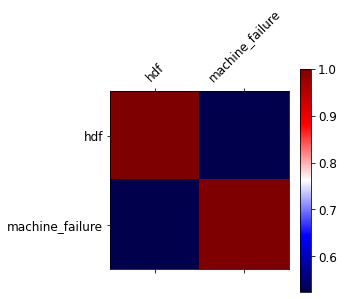

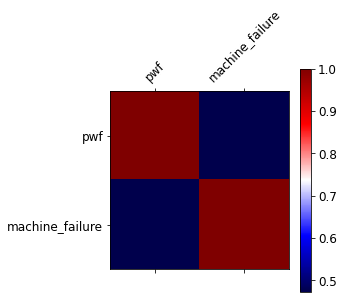

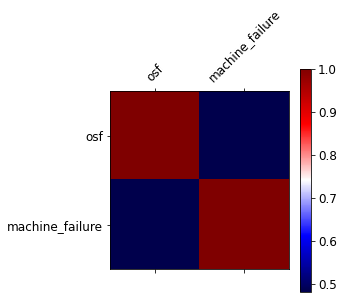

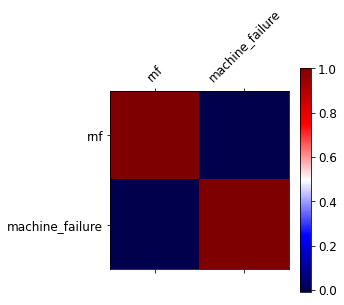

In [ ]:
f = plt.figure(figsize = (4, 4))
ft = ['twf'] + ["machine_failure"]
plt.matshow(df[ft].corr(), fignum=f.number, cmap = 'seismic')
plt.xticks(range(len(ft)), ft, fontsize = 12, rotation = 45)
plt.yticks(range(len(ft)), ft, fontsize = 12)
cb = plt.colorbar()
_ = cb.ax.tick_params(labelsize = 12)

f = plt.figure(figsize = (4, 4))
ft = ['hdf'] + ["machine_failure"]
plt.matshow(df[ft].corr(), fignum=f.number, cmap = 'seismic')
plt.xticks(range(len(ft)), ft, fontsize = 12, rotation = 45)
plt.yticks(range(len(ft)), ft, fontsize = 12)
cb = plt.colorbar()
_ = cb.ax.tick_params(labelsize = 12)

f = plt.figure(figsize = (4, 4))
ft = ['pwf'] + ["machine_failure"]
plt.matshow(df[ft].corr(), fignum=f.number, cmap = 'seismic')
plt.xticks(range(len(ft)), ft, fontsize = 12, rotation = 45)
plt.yticks(range(len(ft)), ft, fontsize = 12)
cb = plt.colorbar()
_ = cb.ax.tick_params(labelsize = 12)

f = plt.figure(figsize = (4, 4))
ft = ['osf'] + ["machine_failure"]
plt.matshow(df[ft].corr(), fignum=f.number, cmap = 'seismic')
plt.xticks(range(len(ft)), ft, fontsize = 12, rotation = 45)
plt.yticks(range(len(ft)), ft, fontsize = 12)
cb = plt.colorbar()
_ = cb.ax.tick_params(labelsize = 12)

f = plt.figure(figsize = (4, 4))
ft = ['rnf'] + ["machine_failure"]
plt.matshow(df[ft].corr(), fignum=f.number, cmap = 'seismic')
plt.xticks(range(len(ft)), ft, fontsize = 12, rotation = 45)
plt.yticks(range(len(ft)), ft, fontsize = 12)
cb = plt.colorbar()
_ = cb.ax.tick_params(labelsize = 12)

Podemos confirmar la alta correlación entre las variables del tipo de falla y "machine_failure".

Se valida la correlación entre *features*.

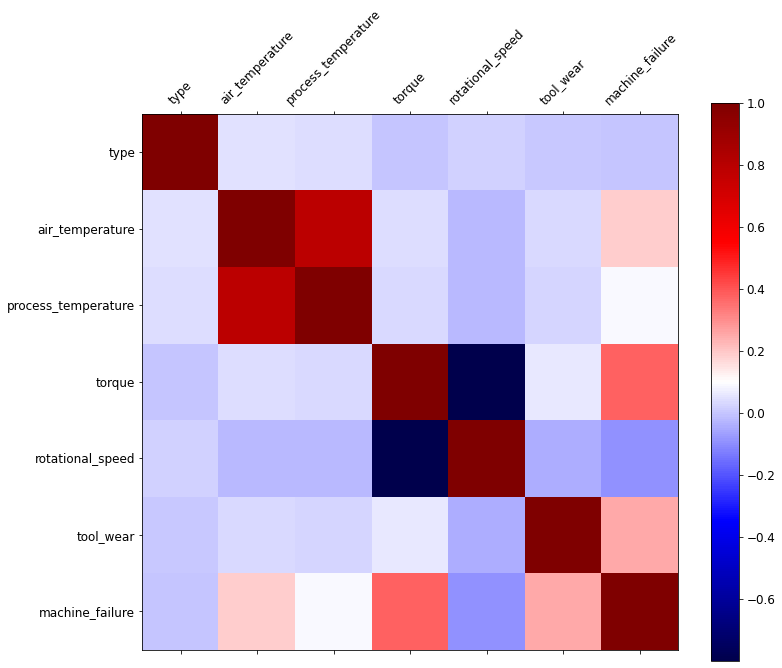

In [ ]:
f = plt.figure(figsize = (12, 10))
ft = features + ["machine_failure"]
plt.matshow(df[ft].corr(), fignum=f.number, cmap = 'seismic')
plt.xticks(range(len(ft)), ft, fontsize = 12, rotation = 45)
plt.yticks(range(len(ft)), ft, fontsize = 12)
cb = plt.colorbar()
_ = cb.ax.tick_params(labelsize = 12)

Se puede ver una baja correlación entre todas las *feautres*, excepto para rotational_speed y torque. Vamos a sacar a rotational_speed de la lista de *features*, ya que su información está reflejada en torque.

In [ ]:
features = ['type', 'air_temperature', 'process_temperature', 'torque', 'tool_wear']

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df[features], df['machine_failure'], test_size=0.2, random_state=0)

In [ ]:
print('Tamaño del conjunto original:', df.shape[0])
print('Tamaño del conjunto de entrenamiento:', X_train.shape[0])
print('Tamaño del conjunto de prueba:', X_test.shape[0])

Tamaño del conjunto original: 1305
Tamaño del conjunto de entrenamiento: 1044
Tamaño del conjunto de prueba: 261


In [ ]:
Y_train.value_counts(normalize = True)

0    0.748084
1    0.251916
Name: machine_failure, dtype: float64

In [ ]:
Y_test.value_counts(normalize = True)

0    0.708812
1    0.291188
Name: machine_failure, dtype: float64

#### Árbol de Decisión

Vamos a hacer la prueba con el algoritmo de Árbol de Decisión. Además, no vamos a controlar la profundidad, para revisar si encuentra la adecuada para encontrar un error de entrenamiento alto y uno bajo de prueba. Dependiendo de los resultados, podremos ver si hay un overfitting (error train bajo, error test alto). Si encontramos overfitting, sabremos que debemos controlar la profundidad, haciendola menor de la que hizo solo.

In [ ]:
tree_model = DecisionTreeClassifier(random_state=1)

In [ ]:
tree_model.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=1)

In [ ]:
tree_model.get_depth()

15

Se visualiza el árbol

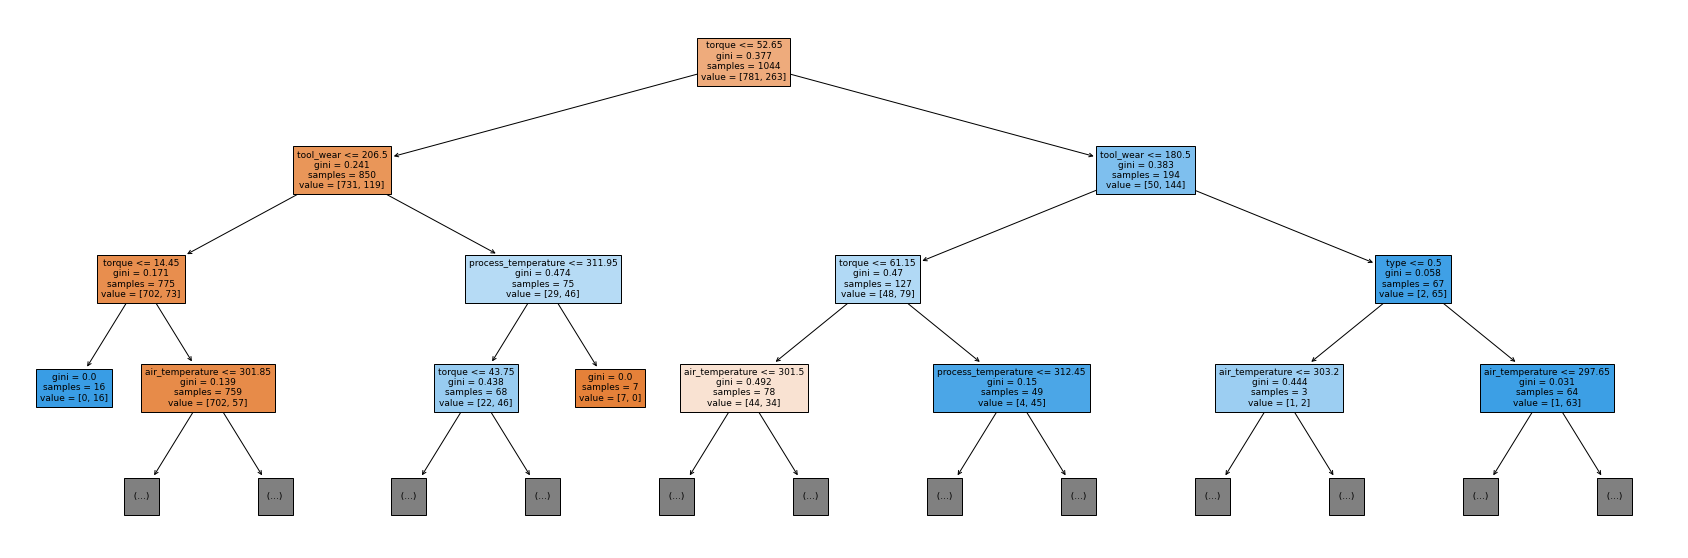

In [ ]:
fig = plt.figure(figsize = (30, 10))
_ = tree.plot_tree(tree_model, max_depth=3, feature_names=features, filled=True, fontsize=9)

In [ ]:
preds_train = tree_model.predict(X_train)
preds_test = tree_model.predict(X_test)

Podemos ver el error del modelo con Matrices de Confusión

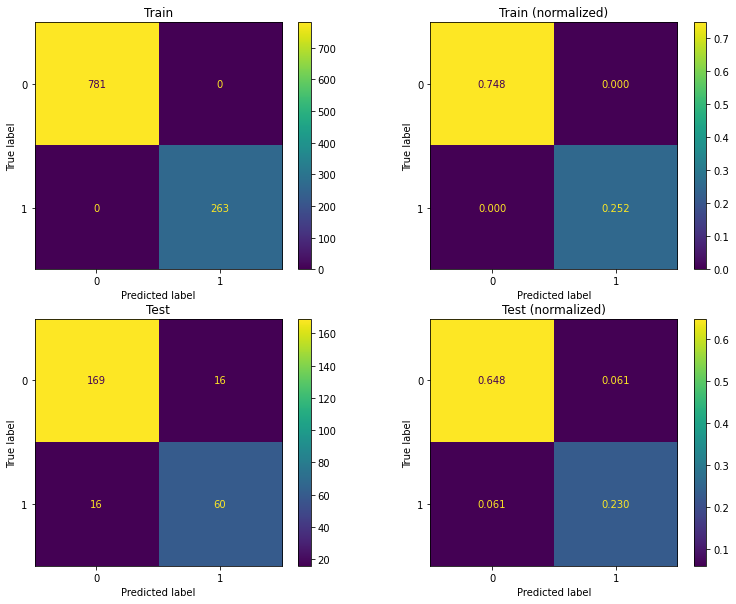

In [ ]:
cm_train = confusion_matrix(Y_train, preds_train, labels = tree_model.classes_)
cm_train_norm = confusion_matrix(Y_train, preds_train, labels = tree_model.classes_, normalize = 'all')
cm_test = confusion_matrix(Y_test, preds_test, labels = tree_model.classes_)
cm_test_norm = confusion_matrix(Y_test, preds_test, labels = tree_model.classes_, normalize = 'all')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (13, 10))
ConfusionMatrixDisplay(confusion_matrix = cm_train, display_labels = tree_model.classes_).plot(ax = ax1, values_format = ',.0f')
ConfusionMatrixDisplay(confusion_matrix = cm_train_norm, display_labels = tree_model.classes_).plot(ax = ax2, values_format = '.3f')
ConfusionMatrixDisplay(confusion_matrix = cm_test, display_labels = tree_model.classes_).plot(ax = ax3, values_format = ',.0f')
ConfusionMatrixDisplay(confusion_matrix = cm_test_norm, display_labels = tree_model.classes_).plot(ax = ax4, values_format = '.3f')

ax1.set_title('Train')
ax2.set_title('Train (normalized)')
ax3.set_title('Test')
ax4.set_title('Test (normalized)')
plt.show()

Con esta matríz de confusión, podemos ver que el modelo está sacando pocos datos clasificados como Errores de Tipo I o Tipo II. Esto es un buen indicio de la calidad del modelo, ya que el porcentaje de datos mal clasificados es poco.

Otra forma de ver el error es revisando las métricas vistas en clase para clasificación

In [ ]:
pd.DataFrame([
    {
        'Train': accuracy_score(Y_train, preds_train),
        'Test': accuracy_score(Y_test, preds_test)
    },
    {
        'Train': precision_score(Y_train, preds_train),
        'Test': precision_score(Y_test, preds_test)
    },
    {
        'Train': recall_score(Y_train, preds_train),
        'Test': recall_score(Y_test, preds_test)
    },
    {
        'Train': f1_score(Y_train, preds_train),
        'Test': f1_score(Y_test, preds_test)
    }
], index = ['Accuracy', 'Precision', 'Recall', 'F1'])

,Train,Test
Accuracy,1.0,0.877395
Precision,1.0,0.789474
Recall,1.0,0.789474
F1,1.0,0.789474


En este caso, vemos una diferencia significativa entre porcentajes de entrenamiento y de test. Para todas las medidas, los valores de entrenamiento son mayores que los de test, confirmando que no hay **overfitting** ni **underfitting**.

Otras conclusiones que podemos hacer son las siguientes:


*   La exactitud nos muestra las instancias clasificadas correctamente. En este caso, hay un 100% de exactitud con la clasificación realizada por el árbol.
*   La precisión nos muestra la fracción de predicciones positivas que efectivamente son positivas. En este caso, un 100% de instancias positivas fueron clasificadas como positivas.
*   El recall nos muestra la fracción de predicciones positivas que se identificaron correctamente. En este caso, hay un 100% de instancias que cumplen con con su identificación.

Algo que también hay que mencionar es la significativa diferencia entre porcentajes de entrenamiento y de prueba. Como el de prueba es ligeramente (la verdad no muy liegramente) menor que el de entrenamiento, puede ser un indicio de que el modelo está teniendo algunos problemas identificando observaciones en el conjunto de prueba, es decir, problemas generalizando el modelo.

Podemos verificar la importancia que da el árbol a cada *feature*.

<Axes: ylabel='Feature'>

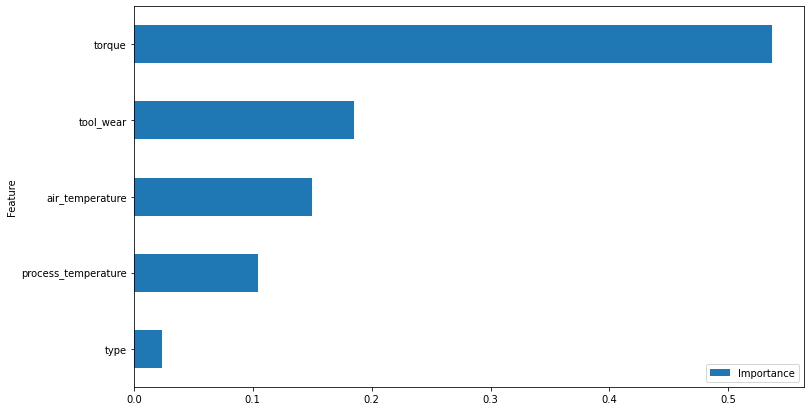

In [ ]:
feature_importance_df = pd.DataFrame([features, tree_model.feature_importances_]).T
feature_importance_df.columns = ['Feature', 'Importance']
feature_importance_df.sort_values(by = 'Importance').plot.barh(x = 'Feature', y = 'Importance', figsize = (12, 7))

#### Bosque Aleatorio

In [ ]:
forest_model = RandomForestClassifier(random_state=2)

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 3, 4, 5]
}

In [ ]:
combinations = 1
for k, v in param_grid.items():
    combinations *= len(v)

print('Total de combinaciones a validar:', combinations)

Total de combinaciones a validar: 128


In [ ]:
# se va a hacer la busqueda solo sobre el 10% de las combinaciones (combinatios/10)
grid_forest_model = RandomizedSearchCV(forest_model, param_grid, n_iter = int(combinations / 10), scoring = ['precision', 'recall', 'f1'], refit = 'f1', cv = 10, n_jobs = -1, verbose = 1)

In [ ]:
grid_forest_model.fit(X_train, Y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


KeyboardInterrupt: ignored

In [ ]:
cv_results_df = pd.DataFrame(grid_forest_model.cv_results_)

In [ ]:
cv_results_df

In [ ]:
grid_forest_model.best_params_

In [ ]:
grid_forest_model.best_score_

In [ ]:
grid_forest_model.best_estimator_

Hacemos un predict del modelo con mejores estimadores

In [ ]:
preds_train = grid_forest_model.best_estimator_.predict(X_train)
preds_test = grid_forest_model.best_estimator_.predict(X_test)

In [ ]:
cm_train = confusion_matrix(Y_train, preds_train, labels = tree_model.classes_)
cm_train_norm = confusion_matrix(Y_train, preds_train, labels = tree_model.classes_, normalize = 'all')
cm_test = confusion_matrix(Y_test, preds_test, labels = tree_model.classes_)
cm_test_norm = confusion_matrix(Y_test, preds_test, labels = tree_model.classes_, normalize = 'all')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (13, 10))
ConfusionMatrixDisplay(confusion_matrix = cm_train, display_labels = tree_model.classes_).plot(ax = ax1, values_format = ',.0f')
ConfusionMatrixDisplay(confusion_matrix = cm_train_norm, display_labels = tree_model.classes_).plot(ax = ax2, values_format = '.3f')
ConfusionMatrixDisplay(confusion_matrix = cm_test, display_labels = tree_model.classes_).plot(ax = ax3, values_format = ',.0f')
ConfusionMatrixDisplay(confusion_matrix = cm_test_norm, display_labels = tree_model.classes_).plot(ax = ax4, values_format = '.3f')

ax1.set_title('Train+Val')
ax2.set_title('Train+Val (normalized)')
ax3.set_title('Test')
ax4.set_title('Test (normalized)')
plt.show()

Con esta matríz de confusión, podemos ver que el modelo está sacando pocos datos clasificados como Errores de Tipo I o Tipo II. Esto es un buen indicio de la calidad del modelo, ya que el porcentaje de datos mal clasificados es poco.

Otra forma de ver el error es revisando las métricas vistas en clase para clasificación

In [ ]:
pd.DataFrame([
    {
        'Train+Val': accuracy_score(Y_train, preds_train),
        'Test': accuracy_score(Y_test, preds_test)
    },
    {
        'Train+Val': precision_score(Y_train, preds_train),
        'Test': precision_score(Y_test, preds_test)
    },
    {
        'Train+Val': recall_score(Y_train, preds_train),
        'Test': recall_score(Y_test, preds_test)
    },
    {
        'Train+Val': f1_score(Y_train, preds_train),
        'Test': f1_score(Y_test, preds_test)
    }
], index = ['Accuracy', 'Precision', 'Recall', 'F1'])

Hay un cambio considerable en el porcentaje de error del modelo, lo que a primera vista puede no ser bueno. Pero, al ver que la diferencia entre el conjunto de entrenamiento y el conjunto de prueba es mucho menor que en el otro modelo (7%-8% en comparación a 15%-20%), podemos acercarnos a pensar que la generalización del modelo es buena. Podemos decir que ese modelo es más estable que el anterior.

Aparte de todo esto, con este modelo, podemos ver la importancia de cada variable para llegar a conclusiones.

In [ ]:
best_est = grid_forest_model.best_estimator_

In [ ]:
feature_importance_df = pd.DataFrame([features, best_est.feature_importances_]).T
feature_importance_df.columns = ['Feature', 'Importance']
feature_importance_df.sort_values(by = 'Importance').plot.barh(x = 'Feature', y = 'Importance', figsize = (12, 7))

Como se puede ver, el torque es el aspecto más importante para definir si una máquina va a presentar fallas. Esto tiene sentido, ya que el torque es de los componentes más importantes para un carro. Este afecta directamente al rendimiento de la máquina, siendo gran parte de la posible falla.
Le sigue el tiempo de desgaste y la temperatura del aire y del proceso.

### Machine Learning, Clustering

#### Selección de *features*

Como variables *feature*, vamos a tener en cuenta los features ya mencionados, además de los tipos de falla.

In [ ]:
features = ['type', 'air_temperature', 'process_temperature', 'torque', 'tool_wear'] + ['twf', 'hdf', 'pwf', 'osf', 'rnf']

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(df[features])

In [ ]:
X.shape

(1305, 10)

#### Agrupación Jerárquica

In [ ]:
cluster_jerarquico = AgglomerativeClustering(metric='manhattan', linkage='complete', compute_distances=True, compute_full_tree=True)

In [ ]:
df['cluster_jerarquico'] = cluster_jerarquico.fit_predict(X)

<Axes: >

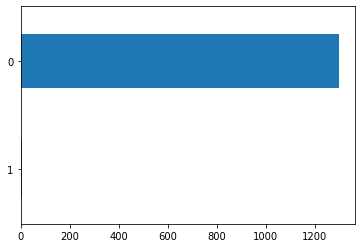

In [ ]:
df['cluster_jerarquico'].value_counts().sort_values().plot.barh()

In [ ]:
columnas_info = []
for each_feature in features:
  columnas_info.append(df[each_feature])

In [ ]:
filas = df['cluster_jerarquico']
tab_crss_jerarquico = []
for each_feature in columnas_info:
  tab_crss = pd.crosstab(filas, each_feature)
  tab_crss_jerarquico.append(tab_crss)

<Axes: xlabel='tool_wear', ylabel='cluster_jerarquico'>

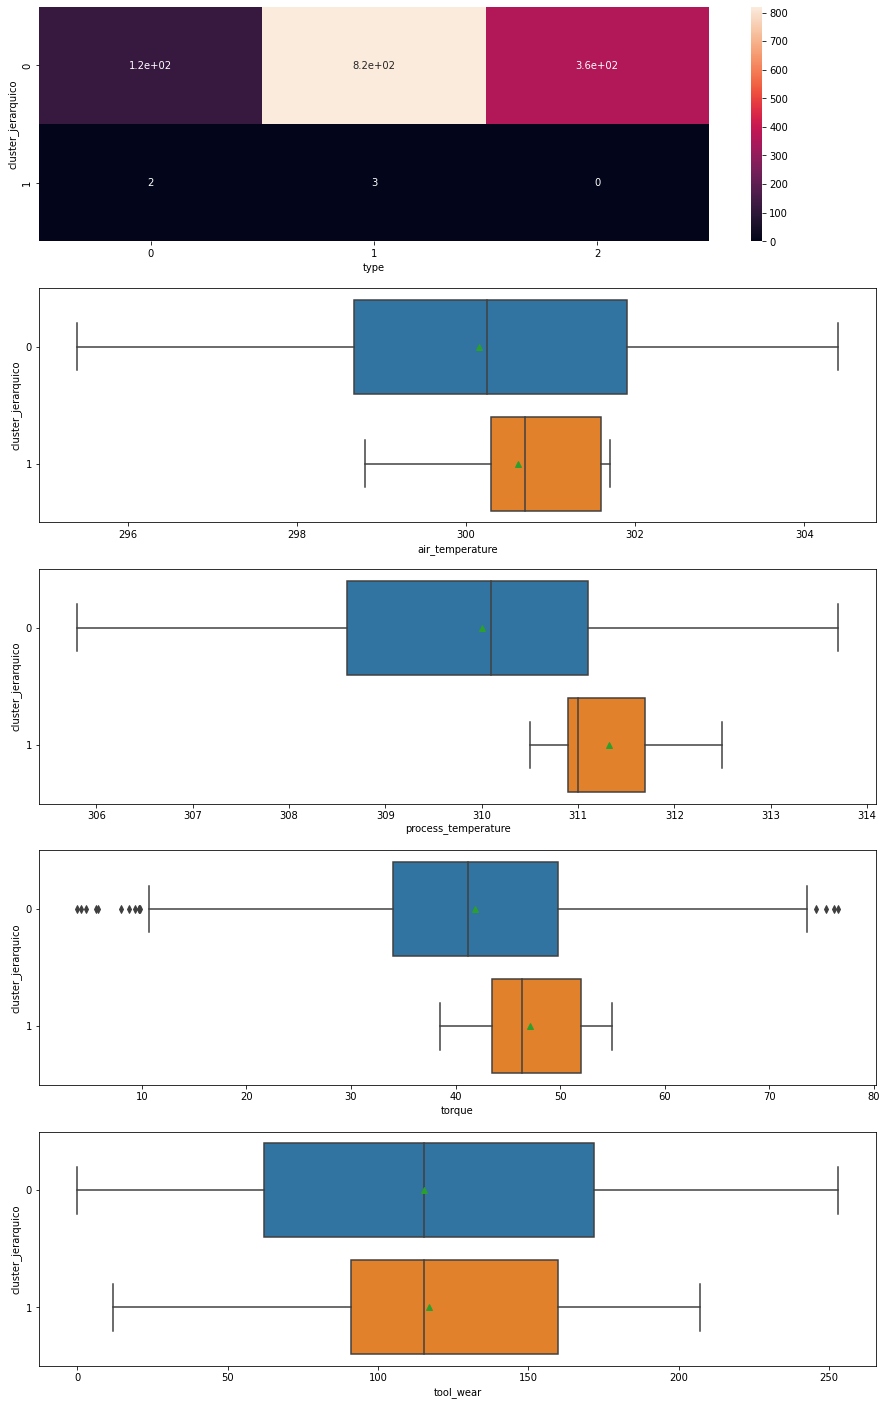

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(15, 25))
sns.heatmap(data=tab_crss_jerarquico[0], annot=True, ax=axes[0])
sns.boxplot(data = df, x = 'air_temperature', y = 'cluster_jerarquico', showmeans = True, orient = 'h', ax = axes[1])
sns.boxplot(data = df, x = 'process_temperature', y = 'cluster_jerarquico', showmeans = True, orient = 'h', ax = axes[2])
sns.boxplot(data = df, x = 'torque', y = 'cluster_jerarquico', showmeans = True, orient = 'h', ax = axes[3])
sns.boxplot(data = df, x = 'tool_wear', y = 'cluster_jerarquico', showmeans = True, orient = 'h', ax = axes[4])

Lo mismo que antes, queremos ver los clusters según el tipo de falla.

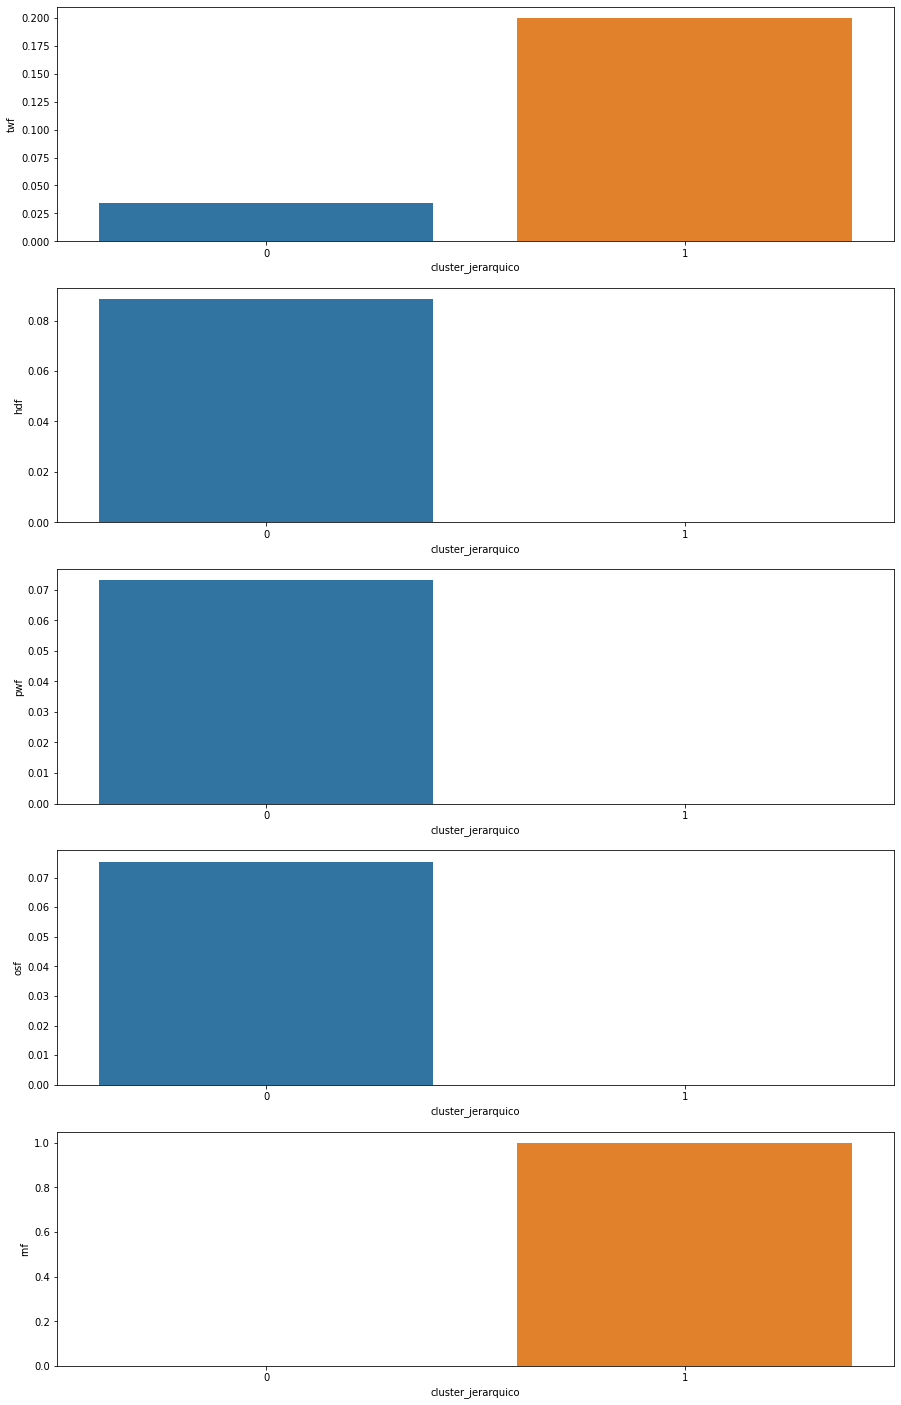

In [ ]:
fig, axes = plt.subplots(5, 1, figsize = (15, 25))
sns.barplot(data = df.groupby('cluster_jerarquico')['twf'].mean().to_frame().reset_index(), x = 'cluster_jerarquico', y = 'twf', ax = axes[0])
sns.barplot(data = df.groupby('cluster_jerarquico')['hdf'].mean().to_frame().reset_index(), x = 'cluster_jerarquico', y = 'hdf', ax = axes[1])
sns.barplot(data = df.groupby('cluster_jerarquico')['pwf'].mean().to_frame().reset_index(), x = 'cluster_jerarquico', y = 'pwf', ax = axes[2])
sns.barplot(data = df.groupby('cluster_jerarquico')['osf'].mean().to_frame().reset_index(), x = 'cluster_jerarquico', y = 'osf', ax = axes[3])
sns.barplot(data = df.groupby('cluster_jerarquico')['rnf'].mean().to_frame().reset_index(), x = 'cluster_jerarquico', y = 'rnf', ax = axes[4])
plt.show()

Podemos graficarlo de otra manera (la gráfica "ideal" para este algoritmo).

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

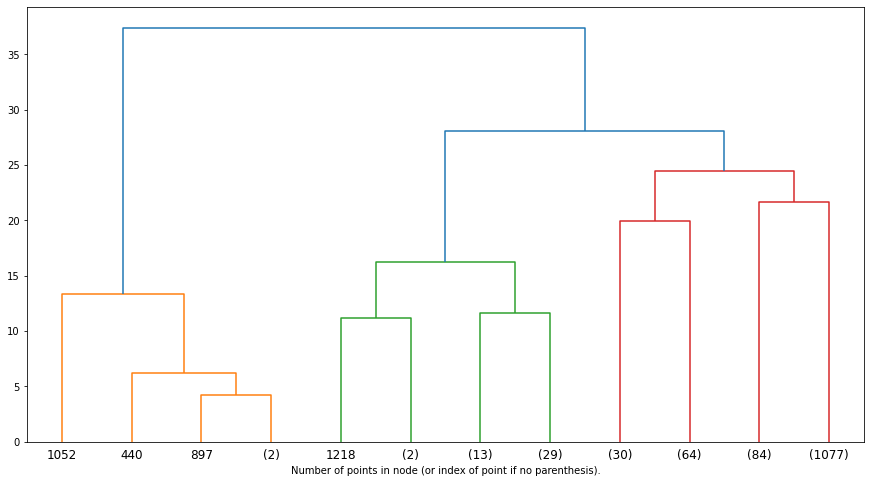

In [ ]:
plt.figure(figsize = (15, 8))
plot_dendrogram(cluster_jerarquico, truncate_mode = 'level', p = 3)
plt.xlabel('Number of points in node (or index of point if no parenthesis).')
plt.show()

#### K-Means

In [ ]:
kmeans = KMeans(n_clusters = 5, init = 'random', n_init = 1)

La selección del número de clusters no está muy justificada. Es el número que, después de *ensayo y error* dio los mejores resultados.

In [ ]:
kmeans.fit(X)

KMeans(init='random', n_clusters=5, n_init=1)

In [ ]:
kmeans.n_iter_

28

<Axes: >

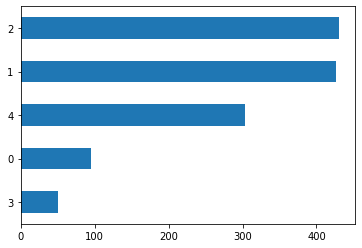

In [ ]:
pd.Series(kmeans.labels_).value_counts().sort_values().plot.barh()

In [ ]:
kmeans.cluster_centers_

array([[-0.20846074, -0.14092262,  0.00928244,  1.24779664,  1.36263677,
        -0.19114637, -0.08806729,  0.16548137,  3.50946243, -0.06201737],
       [-0.13918369,  0.97657237,  0.87987191,  0.05242215, -0.1019359 ,
        -0.19114637,  0.58347162, -0.2079176 , -0.28494393, -0.06201737],
       [-0.61390408, -0.73027944, -0.70389667, -0.25418881, -0.21008997,
        -0.19114637, -0.31086759, -0.25340895, -0.28494393, -0.06201737],
       [-0.14485724,  0.05047235,  0.13084288, -0.26183278,  1.3058173 ,
         4.79777384, -0.31086759, -0.2032192 , -0.05727954,  1.55663592],
       [ 1.15818991, -0.29836753, -0.26029685, -0.06015016, -0.20055408,
        -0.19114637, -0.29922511,  0.63443031, -0.28494393, -0.06201737]])

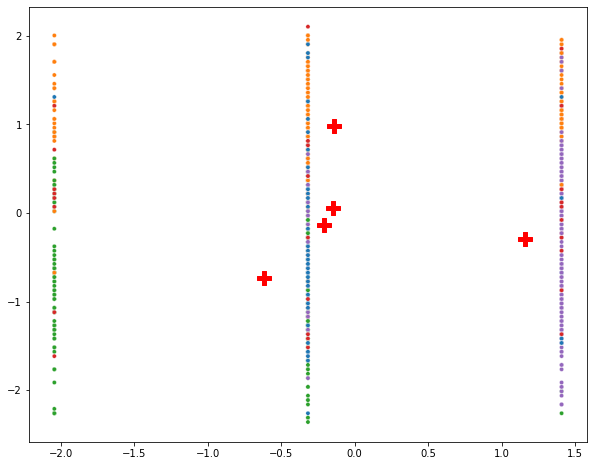

In [ ]:
fig, ax = plt.subplots(figsize = (10, 8))
ax = sns.scatterplot(x = X[:,0], y = X[:,1], hue = kmeans.labels_, palette = 'tab10', size = 1, legend = False)
ax.scatter(x = kmeans.cluster_centers_[:,0], y = kmeans.cluster_centers_[:,1], c = 'red', s = 200, marker = 'P')
plt.show()

Vamos a hacer una validación cualitativa, con la que podremos ver los clusters por *feature*.

In [ ]:
df['cluster'] = kmeans.predict(X)

<Axes: >

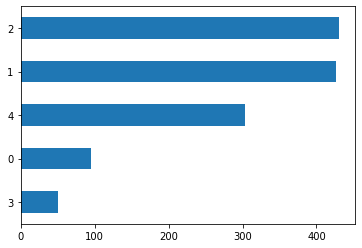

In [ ]:
df['cluster'].value_counts().sort_values().plot.barh()

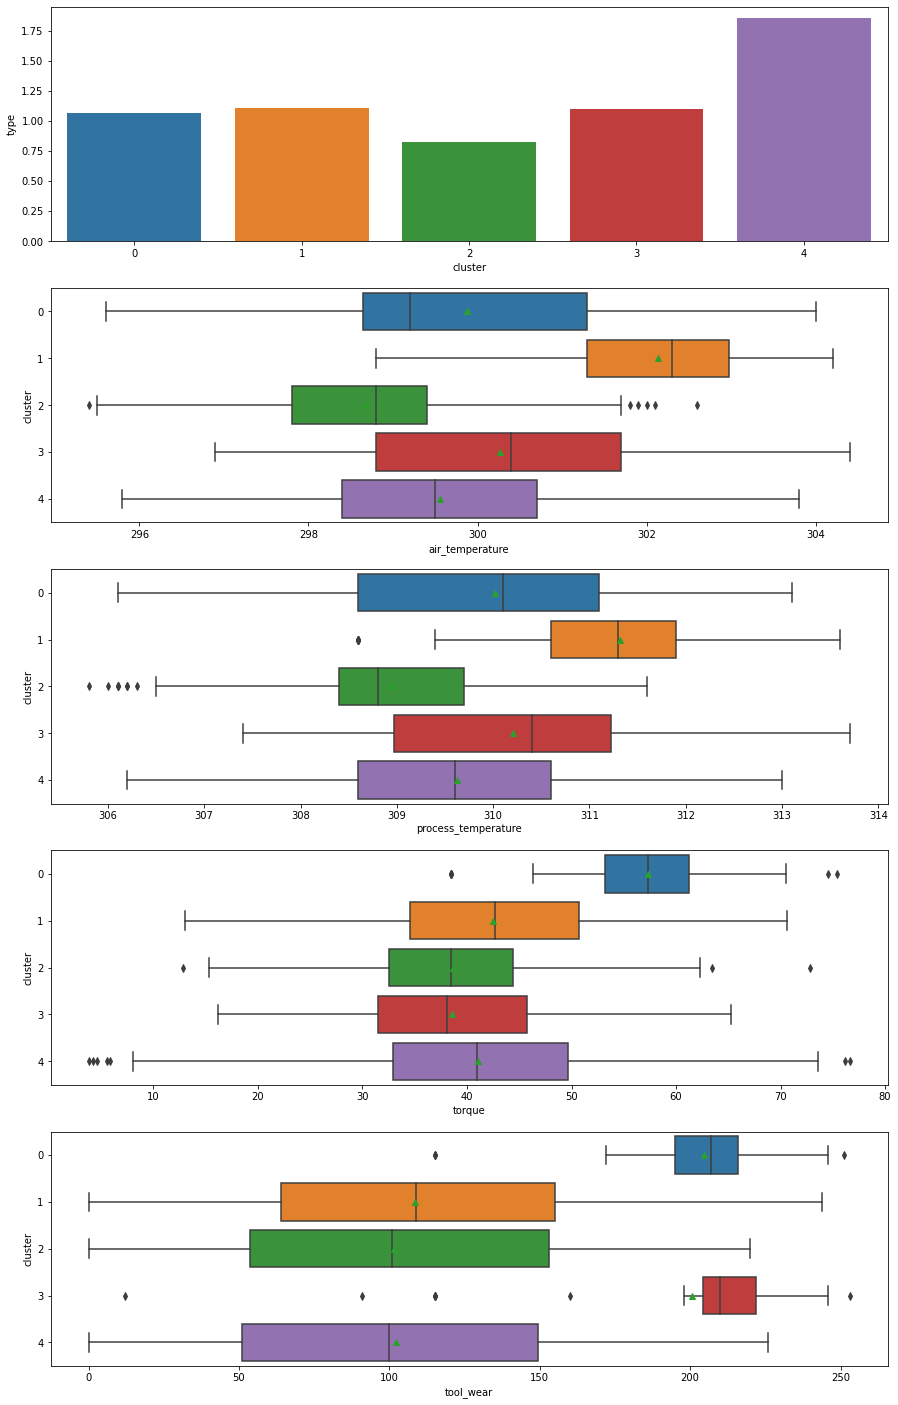

In [ ]:
fig, axes = plt.subplots(5, 1, figsize = (15, 25))
sns.barplot(data = df.groupby('cluster')['type'].mean().to_frame().reset_index(), x = 'cluster', y = 'type', ax = axes[0])
sns.boxplot(data = df, x = 'air_temperature', y = 'cluster', showmeans = True, orient = 'h', ax = axes[1])
sns.boxplot(data = df, x = 'process_temperature', y = 'cluster', showmeans = True, orient = 'h', ax = axes[2])
sns.boxplot(data = df, x = 'torque', y = 'cluster', showmeans = True, orient = 'h', ax = axes[3])
sns.boxplot(data = df, x = 'tool_wear', y = 'cluster', showmeans = True, orient = 'h', ax = axes[4])
plt.show()

Pero, en este caso, lo que más nos importa es clusters para los tipos de falla y sus características particulares.

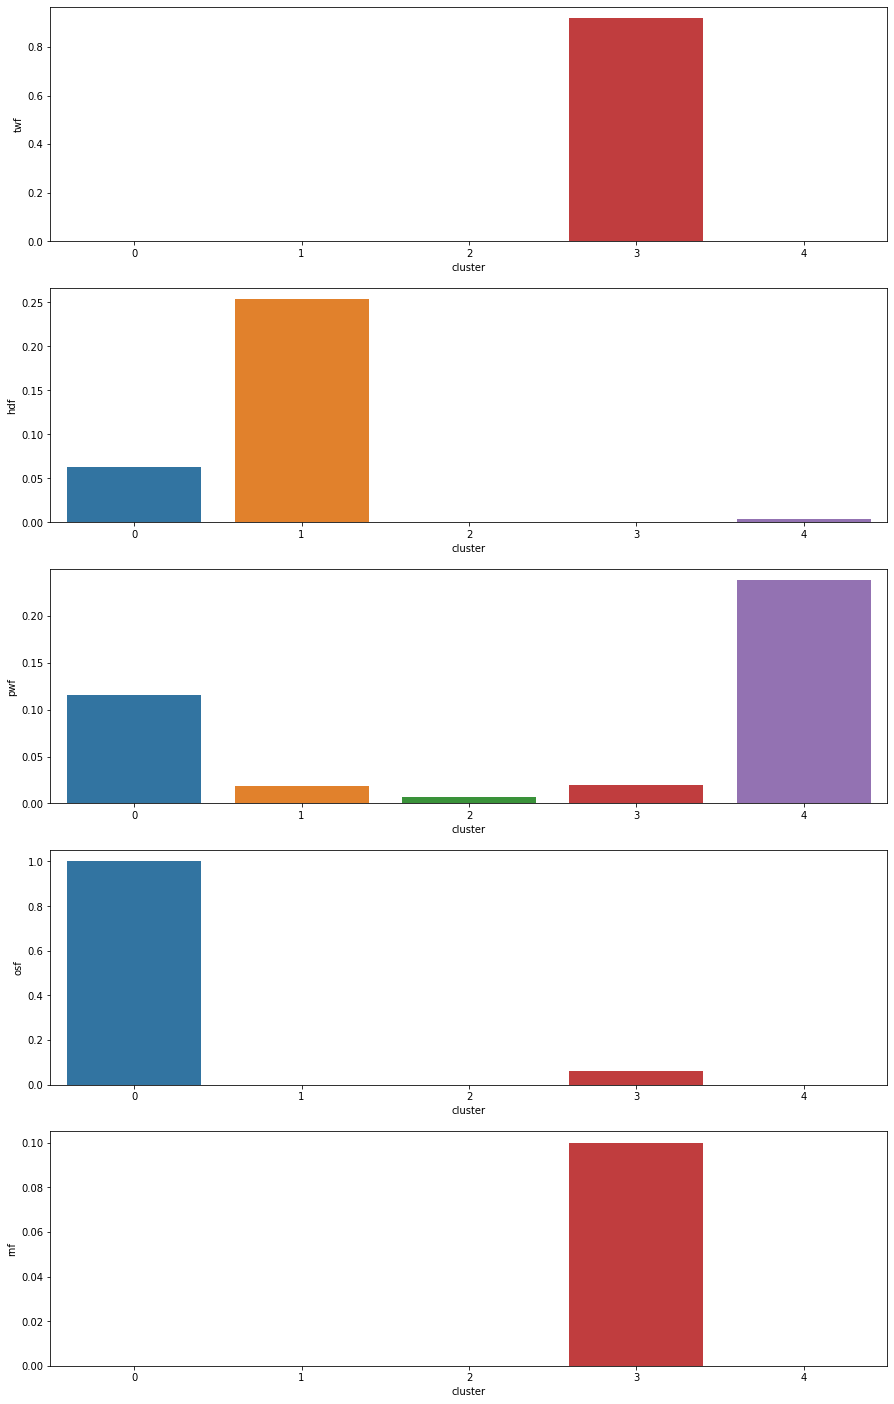

In [ ]:
fig, axes = plt.subplots(5, 1, figsize = (15, 25))
sns.barplot(data = df.groupby('cluster')['twf'].mean().to_frame().reset_index(), x = 'cluster', y = 'twf', ax = axes[0])
sns.barplot(data = df.groupby('cluster')['hdf'].mean().to_frame().reset_index(), x = 'cluster', y = 'hdf', ax = axes[1])
sns.barplot(data = df.groupby('cluster')['pwf'].mean().to_frame().reset_index(), x = 'cluster', y = 'pwf', ax = axes[2])
sns.barplot(data = df.groupby('cluster')['osf'].mean().to_frame().reset_index(), x = 'cluster', y = 'osf', ax = axes[3])
sns.barplot(data = df.groupby('cluster')['rnf'].mean().to_frame().reset_index(), x = 'cluster', y = 'rnf', ax = axes[4])
plt.show()

Se pueden ver diferencias sgnificativas entre clusters:

*   Sobre el fallo por desgaste (twf): Este tipo de falla se presenta más con máquinas con tiempo de desgaste muy altos (210) y rangos de temperatura altos (298-302).
*   Sobre el fallo por disipación de calor (hdf): Este tipo de falla se presenta más con máquinas con temperaturas altas (310) y rango de tiempo de desgaste grande (50-150).
*   Sobre el fallo por energía insuficiente (pwf): Este tipo de falla se presenta más con máquinas con características entre tiempo de desgaste, torque, y temperaturas altas. Para este tipo, todas las características tienen rangos grandes que llegan a valores mu altos. Este se debe a que este fallo está presente en todos los clusters.
*   Sobre el fallo por uso contínuo excesivo (osf): Este tipo de falla se presenta más con máquinas con tiempo de desgaste, torque y temperaturas altos.
*   Sobre otros tipos de fallas, podemos ver que tienen características más cercanas a las de el fallo por desgaste, es decir, tiempo de descarte altos y temperatura grandes.

Algunos aspectos predominantes entre fallas es, por ejemplo, el fallo por desgaste tiene tiempo de desgaste mayor al de cualquier otro fallo. El rango de tempertaturas del fallo por disipación de calor es mayor al de otras fallas.El torque del tipo de falla por contínuo excesivo es mayor al de cualquier otro tipo de falla.

